In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import numpy
import torch
from time import time
from tqdm import tqdm

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
cwd = os.getcwd()
NOTEBOOK_DIR = os.path.dirname(cwd+'/')
ROOT = os.path.dirname(NOTEBOOK_DIR)

import sys
sys.path.append(ROOT)

In [4]:
from utils.tools import *

# Constants

In [5]:
INPUT_DIM = 2 #50
BIAS = False

SEED = 42
N_TRAIN = 256
BATCH_SIZE = 64
ALPHA = 1e-1
BASE_LR = 1.0e-2
N_STEPS = int(1.5e3)
N_VAL = 100
VAL_ITER = 100
N_MAX_NEURONS = 2000

EPS = 1.0e-7
ALPHA = 0.1
BETA = 1.0
LAMBDA = 0.0 #0.01
TAU = 1.0

In [6]:
FIGURES_DIR = os.path.join(ROOT, 'figures/kernel_penalty_variants/')
create_dir(FIGURES_DIR)

In [7]:
set_random_seeds(SEED)

## Common functions

In [8]:
def forward(a, b, x):
    m = a.shape[1]
    if m == 0:
        return 0.
    return np.matmul(np.maximum(np.matmul(x, b.T), 0), a.T) #/ a.shape[1]

In [9]:
def H(c, u, kappa, sigma=1.0):
    if kappa == 'kappa_1':
        kappa = kappa_1
    elif kappa == 'kappa_2':
        kappa = kappa_2
    elif kappa == 'kappa_3':
        kappa = kappa_3
    else:
        kappa = kappa_1
    gram_mat = np.matmul(u, u.T)
    K = kappa(gram_mat, sigma=sigma)
    return 0.5 * np.matmul(np.abs(c), np.matmul(K, np.abs(c.T)))

In [10]:
# ATTRACTIVE
def kappa_1(s, sigma=1.0):
    return 1 - np.exp((s - 1) / sigma**2)

In [11]:
# REPULSIVE
def kappa_3(s, sigma=1.0):
    return np.exp((s - 1) / sigma**2)

In [12]:
def projected_conic_update(x, y, c, u, kappa, sigma=1.0, penalty=True):
    if kappa == 'kappa_1':
        grad_sign = -1.0
        kappa = kappa_1
    elif kappa == 'kappa_3':
        grad_sign = 1.0
        kappa = kappa_3
    else:
        grad_sign = 1.0
    signs = np.sign(c)    
    y_hat = forward(c, u, x)
    n = x.shape[0]
    
    gram_mat = np.matmul(u, u.T)
    K = kappa(gram_mat, sigma=sigma)
    
    # mass updates
    grad_H = np.matmul(np.abs(c), K)
    grad_J = np.matmul((y_hat - y).T, np.maximum(np.matmul(x, u.T), 0)) / n
    grad = TAU * signs * grad_J # signs for the data-fitting term
    if penalty:
        #grad += LAMBDA * grad_H
        pass
    grad_norm = np.mean(np.linalg.norm(grad, axis=1, ord=2, keepdims=True))
    grad = (grad / grad_norm) * np.minimum(grad_norm, 0.001)
    c = (1 - 2 * ETA * grad) * c  # no sign here since only the absolute values of the masses interact in the penalty
    
    # position updates
    #grad_H = grad_sign * (1 / sigma**2) * (np.matmul(np.abs(c) * K, u) - np.matmul(K * gram_mat, np.abs(c).T) * u)
    #grad_H = -(1 / sigma**2) * (np.matmul(c * K, u) - np.matmul(K * gram_mat, c.T) * u)
    #grad_H = (1 / sigma**2) * (np.matmul(np.abs(c) * K, u) - np.matmul(K * gram_mat, np.abs(c.T)) * u)
    # adjusted learning rate
    grad_H = grad_sign * (np.matmul(np.abs(c) * K, u) - np.matmul(K * gram_mat, np.abs(c).T) * u)
    grad_J = np.matmul(np.heaviside(np.matmul(u, x.T), 0), (y_hat - y)*x) / n
    grad = TAU * signs.T * grad_J
    
    if penalty:
        grad += LAMBDA * grad_H
    #grad_norm = np.mean(np.linalg.norm(grad, axis=1, ord=2, keepdims=True))
    #grad = (grad / grad_norm) * np.minimum(grad_norm, 0.001)
    
    u = u - ETA * grad
    
    # re-normalize particle positions on the sphere
    u = u / np.linalg.norm(u, axis=1, ord=2, keepdims=True)
    
    return c, u, grad, K

In [13]:
def remove_neurons(c, u, eps=1e-4):            
    squared_dists = 2 * (1 - np.matmul(u, u.T))  # vectors in u are of unit norm
    squared_dists += np.identity(len(squared_dists))
    dist_indexes_to_remove = np.argwhere(squared_dists < (eps**2))
    
    if len(dist_indexes_to_remove) > 0:
        cpt = 0
        i0, j = dist_indexes_to_remove[0]
        to_merge = {i0 : []}
        merged = set([i0])
        for k in range(len(dist_indexes_to_remove)):
            i, j = dist_indexes_to_remove[k]
            if i == i0:
                to_merge[i0].append(j)
                merged.add(j)
            else:
                if i not in merged:
                    i0 = i
                    merged.add(i)
                    to_merge[i] = []
                    if j not in merged:
                        to_merge[i].append(j)
                        merged.add(i)
                        merged.add(j)
        
        index_to_remove = []
        for i, js in to_merge.items():
            index_to_remove += js
            if len(js) > 0:
                c[0, i] += np.sum(c[0, js])

        u = np.delete(u, index_to_remove, axis=0)
        c = np.delete(c, index_to_remove, axis=1)
    
    return c, u

In [14]:
def add_neuron(c, u, x, y, kappa, penalty=False, n_init=2):
    new_u = np.random.normal(size=(1, INPUT_DIM))
    new_u = new_u / np.linalg.norm(new_u, axis=1, ord=2, keepdims=True)

    if kappa == 'kappa_1':
        grad_sign = -1.0
        kappa = kappa_1
    elif kappa == 'kappa_3':
        grad_sign = 1.0
        kappa = kappa_3
    else:
        grad_sign = 1.0

    n = x.shape[0]
    if (c is None) or (u is None):
        new_u = np.random.normal(size=(n_init, INPUT_DIM))
        new_u = new_u / np.linalg.norm(new_u, axis=1, ord=2, keepdims=True)
        
        # mass update
        y_hat = 0
        grad_J = np.matmul((y_hat - y).T, np.maximum(np.matmul(x, new_u.T), 0)) / n
        grad = TAU * grad_J
        #grad = grad_J
        
        #c = - ALPHA * (grad + np.random.normal(size=grad.shape))
        c = - ALPHA * grad
        u = new_u
    
    else:    
        new_u = np.random.normal(size=(1, INPUT_DIM))
        new_u = new_u / np.linalg.norm(new_u, axis=1, ord=2, keepdims=True)
        
        y_hat = forward(c, u, x)
        signs = np.sign(c)    
        gram_mat = np.matmul(u, new_u.T)
        K = kappa(gram_mat, sigma=sigma)

        # mass updates
        if penalty:
            grad_H = np.matmul(np.abs(c), K)
        else:
            grad_H = 0
        grad_J = np.matmul((y_hat - y).T, np.maximum(np.matmul(x, new_u.T), 0)) / n

        grad = TAU * grad_J + LAMBDA * grad_H  # signs for the data-fitting term
        
        #grad_norm = np.mean(np.linalg.norm(grad, axis=1, ord=2, keepdims=True))
        #grad = (grad / grad_norm) * np.minimum(grad_norm, 0.02)

        new_c = - ALPHA * grad
        c = np.hstack((c, new_c))
        u = np.vstack((u, new_u))
    return c, u

## Data

In [15]:
INPUT_DIM = 10 # 10
noise = 1e-5

m_star = 50
a_star = np.random.normal(size=(1, m_star))
b_star = np.random.normal(size=(m_star, INPUT_DIM)) / np.sqrt(INPUT_DIM)

n_train = 50
x_train = np.random.normal(size=(n_train, INPUT_DIM))
x_train = x_train / np.linalg.norm(x_train, axis=1, ord=2, keepdims=True)
y_train = forward(a_star, b_star, x_train) / m_star + noise * np.random.normal(size=(n_train, 1))

n_val = 50
x_val = np.random.normal(size=(n_val, INPUT_DIM))
x_val = x_val / np.linalg.norm(x_val, axis=1, ord=2, keepdims=True)
y_val = forward(a_star, b_star, x_val) / m_star + noise * np.random.normal(size=(n_val, 1))

## Training

In [16]:
def train(c, u, kappa, sigma=1.0, eps=1e-4, conic=False, dynamic=True, n_updates=1, pop_penalty=False, pop=True, 
          penalty=True):
    us = [u]
    cs = [c]
    m0 = c.shape[1]
    ms = [c.shape[1]]
    y_hat = forward(c, u, x_train)
    y_hats = [y_hat]
    
    Ks = []
    
    loss = TAU * np.mean((y_hat - y_train)**2) /2
    losses = [loss]
    penalized_losses = [loss + LAMBDA * H(c, u, kappa, sigma)[0, 0]]
    grads = []
    
    for k in range(N_STEPS // n_updates):
        if pop:
            if conic:
                if c.shape[1] < N_MAX_NEURONS:
                    if k % 2 == 0:
                        c, u = add_neuron(c, u, x_train, y_train, kappa, penalty=pop_penalty)
                    else:      
                        for _ in range(n_updates):
                            c, u, grad, K = projected_conic_update(x_train, y_train, c, u, kappa=kappa, sigma=sigma, 
                                                                penalty=penalty)
                            grads.append(grad)
                            Ks.append(K)
                        if dynamic:
                            c, u = remove_neurons(c, u, eps=eps)
#                        if c.shape[1] < m0:
#                            c, u = add_neuron(c, u, x_train, y_train, kappa, penalty)

            else:
                c, u = add_neuron(c, u, x_train, y_train, kappa, penalty=pop_penalty)
                        
        else:
            for _ in range(n_updates):
                c, u, grad = projected_conic_update(x_train, y_train, c, u, kappa=kappa, sigma=sigma, penalty=penalty)

        
            if dynamic:
                c, u = remove_neurons(c, u, eps=eps)
                if conic:
                    if c.shape[1] < m0:
                        c, u = add_neuron(c, u, x_train, y_train, kappa, penalty=pop_penalty)
                    
        ms.append(c.shape[1])
        
        y_hat = forward(c, u, x_train)
        loss = TAU * np.mean((y_hat - y_train)**2) / 2
        penalized_loss = loss + LAMBDA * H(c, u, kappa, sigma)[0, 0]
        y_hats.append(y_hat)
        
        cs.append(c)
        us.append(u)
        losses.append(loss)
        penalized_losses.append(penalized_loss)
        
    return cs, us, np.array(losses), np.array(penalized_losses), ms, y_hats, grads, Ks

In [17]:
def validation(c, u, conic=False):
    y_hat = forward(c, u, x_val)
    loss = TAU * np.mean((y_hat - y_val)**2) / 2
    if conic:
        penalized_loss = loss
    else:
        penalized_loss = loss + LAMBDA * H(c, u, kappa, sigma)[0, 0]
    return loss, penalized_loss

## 1. Usual pop-conic with and without penalty

In [18]:
# REPULSIVE makes more sense as the pop step does not increase the penalized loss
N_MAX_NEURONS = 3000
ETA = 0.01
sigma = 0.5 # 0.3
N_STEPS = 3000 #30000 #6000 #3000
eps = 0.08 # 0.6
n_updates = 2

TAU = 1.0 #1.0
ALPHA = 0.1 ## 1.0 ---> CRUCIAL !!
LAMBDA = 0.01 # 1.0, 0.5 0.02
kappa = 'kappa_1' # 'kappa_3'

# POP-CONIC-PENALTY
pop_penalty = True # False
dynamic = True
pop = True
conic = True
penalty = True
n_init = 2
c0_, u0_ = add_neuron(None, None, x_train, y_train, kappa, n_init=n_init)
c, u, losses3, penalized_losses3, ms3, _, grads, Ks = \
        train(c0_, u0_, kappa=kappa, sigma=sigma, eps=eps, n_updates=n_updates, 
              conic=conic, dynamic=dynamic, pop_penalty=pop_penalty, pop=pop, penalty=penalty)
#        train(c0, u0, kappa='kappa_1', sigma=sigma, eps=eps, dynamic=dynamic, n_updates=n_updates, penalty=penalty)

# POP-CONIC
#pop_penalty = False
#dynamic = True
#pop = True
#conic = True
#penalty = False
#c, u, losses_pop, penalized_losses_pop, ms_pop, _ = \
#        train(c0_, u0_, kappa=kappa, sigma=sigma, eps=eps, n_updates=n_updates, 
#              conic=conic, dynamic=dynamic, pop_penalty=pop_penalty, pop=pop, penalty=penalty)

In [19]:
grad_norms = [np.mean(np.linalg.norm(grad_, axis=1, ord=2, keepdims=True)) for grad_ in grads]

In [20]:
u_ = u[-1]

if kappa == 'kappa_1':
    grad_sign = -1.0
    kappa = kappa_1
elif kappa == 'kappa_3':
    grad_sign = 1.0
    kappa = kappa_3
else:
    pass
gram_mat = np.matmul(u_, u_.T)
K = kappa(gram_mat, sigma=sigma)

In [21]:
K.shape

(752, 752)

In [22]:
K

array([[ 0.00000000e+00,  9.55273503e-01,  9.53433170e-01, ...,
         9.93861771e-01,  9.21062370e-01,  9.93767125e-01],
       [ 9.55273503e-01,  0.00000000e+00,  9.87546766e-01, ...,
         9.65983510e-01,  9.68543806e-01,  9.92943981e-01],
       [ 9.53433170e-01,  9.87546766e-01,  8.88178420e-16, ...,
         9.90983416e-01,  9.23793742e-01,  9.80317802e-01],
       ...,
       [ 9.93861771e-01,  9.65983510e-01,  9.90983416e-01, ...,
        -8.88178420e-16,  9.42766969e-01,  9.91143554e-01],
       [ 9.21062370e-01,  9.68543806e-01,  9.23793742e-01, ...,
         9.42766969e-01,  0.00000000e+00,  9.93642453e-01],
       [ 9.93767125e-01,  9.92943981e-01,  9.80317802e-01, ...,
         9.91143554e-01,  9.93642453e-01,  4.44089210e-16]])

In [23]:
len(K[K>0.9]) / K.size

0.9014790346310547

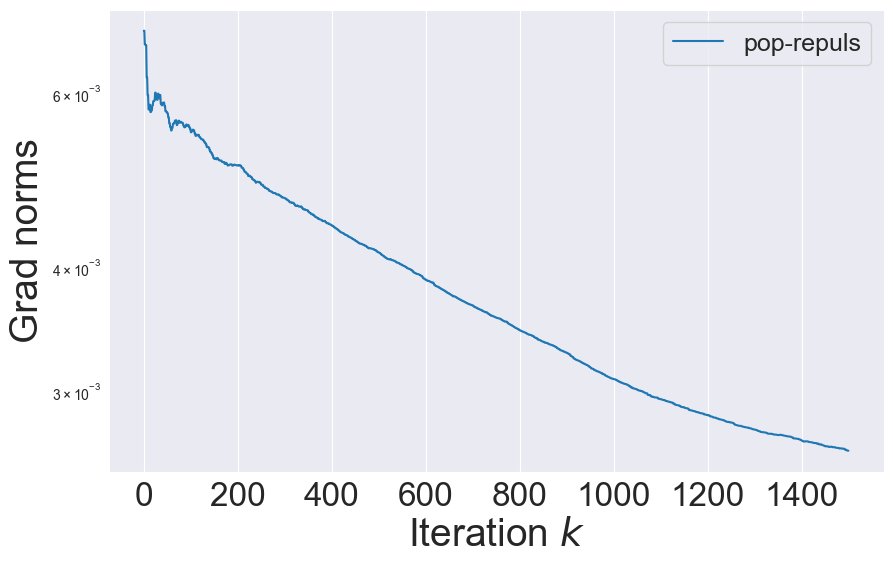

In [24]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
plt.yscale('log')

plt.plot(np.arange(len(grad_norms)), grad_norms, label='pop-repuls')
#plt.plot(np.arange(len(train_losses_mix_conic)), train_losses_mix_conic, label='mix-conic')

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Grad norms', fontsize=28)
#plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

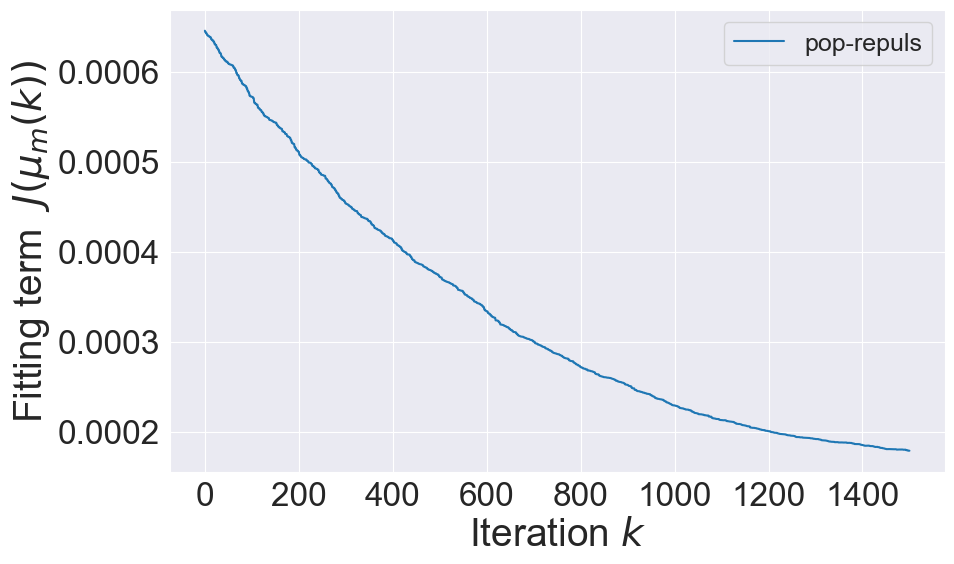

In [25]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(losses3)), losses3, label='pop-repuls')
#plt.plot(np.arange(len(losses_pop)), losses_pop, label='pop-conic')
#plt.plot(np.arange(len(train_losses_mix_conic)), train_losses_mix_conic, label='mix-conic')

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Fitting term $\\ J(\\mu_m(k))$', fontsize=28)
#plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

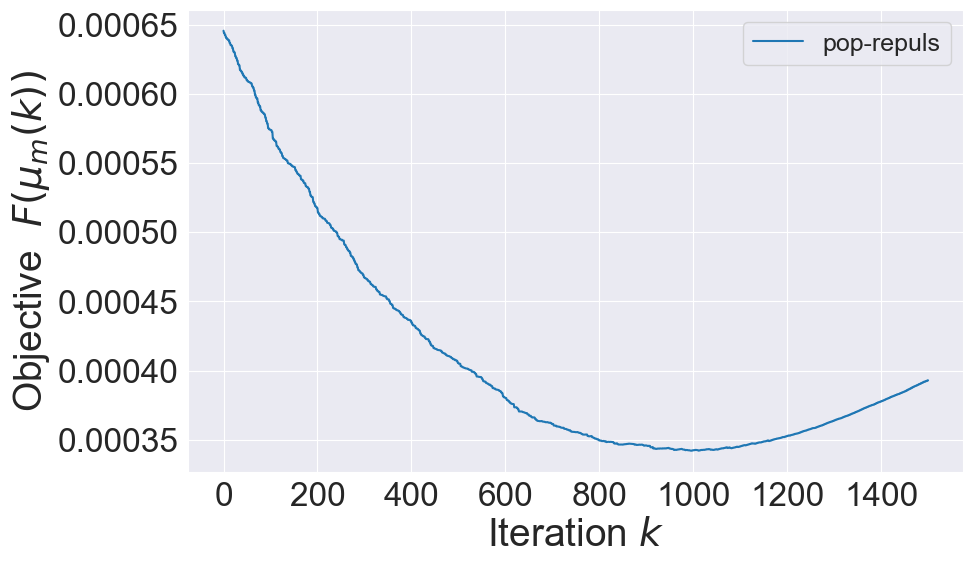

In [26]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')

#plt.yscale('log')

k_min, k_max = 0, N_STEPS + 1

plt.plot(np.arange(len(penalized_losses3))[k_min:k_max], penalized_losses3[k_min:k_max], label='pop-repuls')
#plt.plot(np.arange(len(penalized_losses_pop)), penalized_losses_pop, label='pop-conic')
#plt.plot(np.arange(len(penalized_train_losses_mix_coni c)), penalized_train_losses_mix_conic, label='mix-conic')

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Objective $\\ F(\\mu_m(k))$', fontsize=28)
#plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

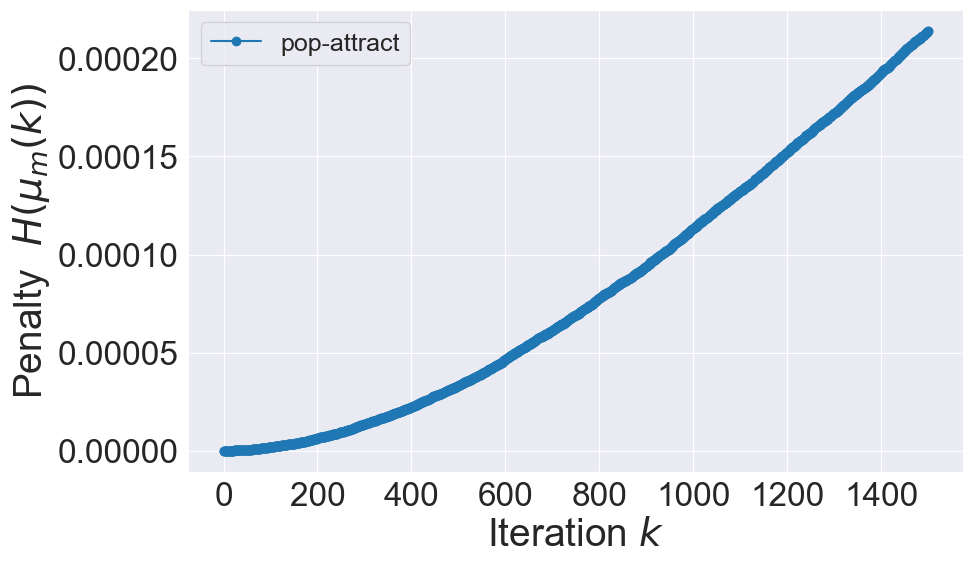

In [27]:
penalties = penalized_losses3 - losses3

plt.figure(figsize=(10, 6))
marker =  'o' # None
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(penalties)), penalties, label='pop-attract', marker=marker)
#plt.plot(np.arange(len(losses_pop)), losses_pop, label='pop-conic')
#plt.plot(np.arange(len(train_losses_mix_conic)), train_losses_mix_conic, label='mix-conic')

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Penalty $\\ H(\\mu_m(k))$', fontsize=28)
#plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

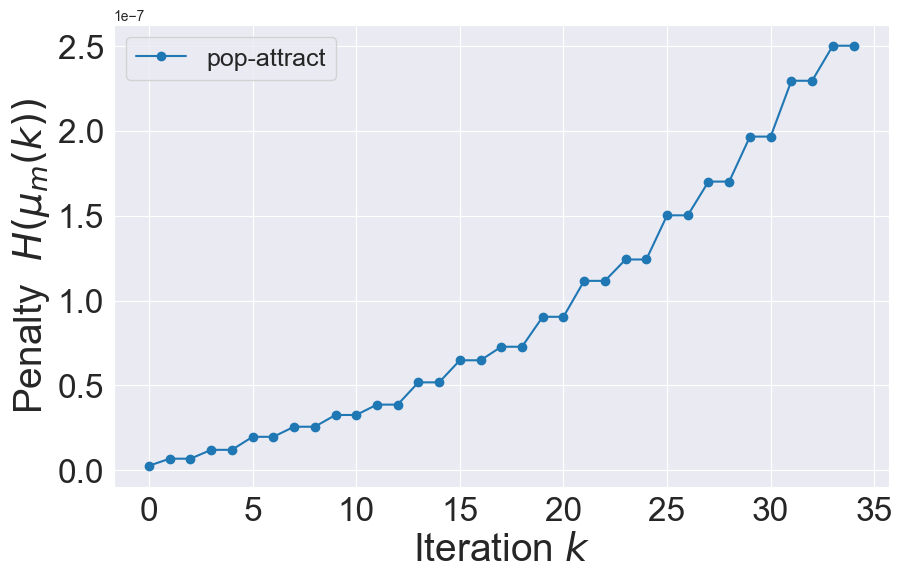

In [28]:
penalties = penalized_losses3 - losses3

plt.figure(figsize=(10, 6))
marker =  'o' # None
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(penalties))[:35], penalties[:35], label='pop-attract', marker=marker)
#plt.plot(np.arange(len(losses_pop)), losses_pop, label='pop-conic')
#plt.plot(np.arange(len(train_losses_mix_conic)), train_losses_mix_conic, label='mix-conic')

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Penalty $\\ H(\\mu_m(k))$', fontsize=28)
#plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

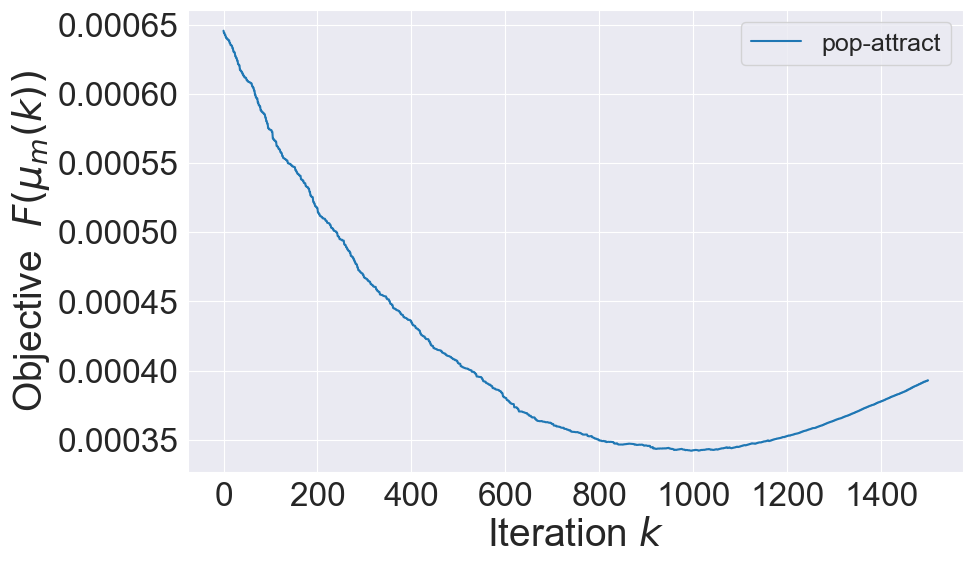

In [29]:
#### MAYBE THE PROBLME COMES FROM THE ABSOLUTE VALUES IN THE KERNEL PENALTY <#####

plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(penalized_losses3)), penalized_losses3, label='pop-attract')
#plt.plot(np.arange(len(penalized_losses_pop)), penalized_losses_pop, label='pop-conic')
#plt.plot(np.arange(len(penalized_train_losses_mix_conic)), penalized_train_losses_mix_conic, label='mix-conic')

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Objective $\\ F(\\mu_m(k))$', fontsize=28)
#plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

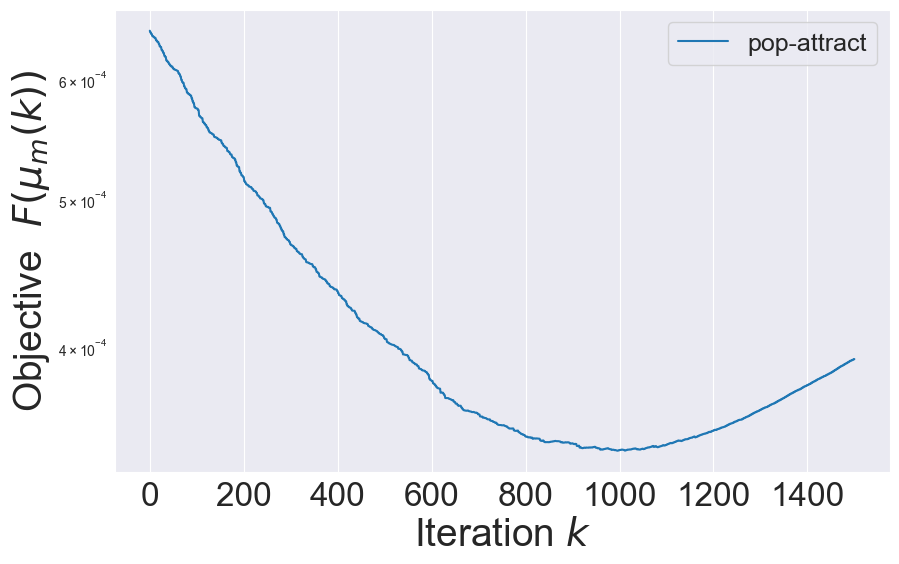

In [30]:
#### MAYBE THE PROBLME COMES FROM THE ABSOLUTE VALUES IN THE KERNEL PENALTY <#####

plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
plt.yscale('log')

plt.plot(np.arange(len(penalized_losses3)), penalized_losses3, label='pop-attract')
#plt.plot(np.arange(len(penalized_losses_pop)), penalized_losses_pop, label='pop-conic')
#plt.plot(np.arange(len(penalized_train_losses_mix_conic)), penalized_train_losses_mix_conic, label='mix-conic')

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Objective $\\ F(\\mu_m(k))$', fontsize=28)
#plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

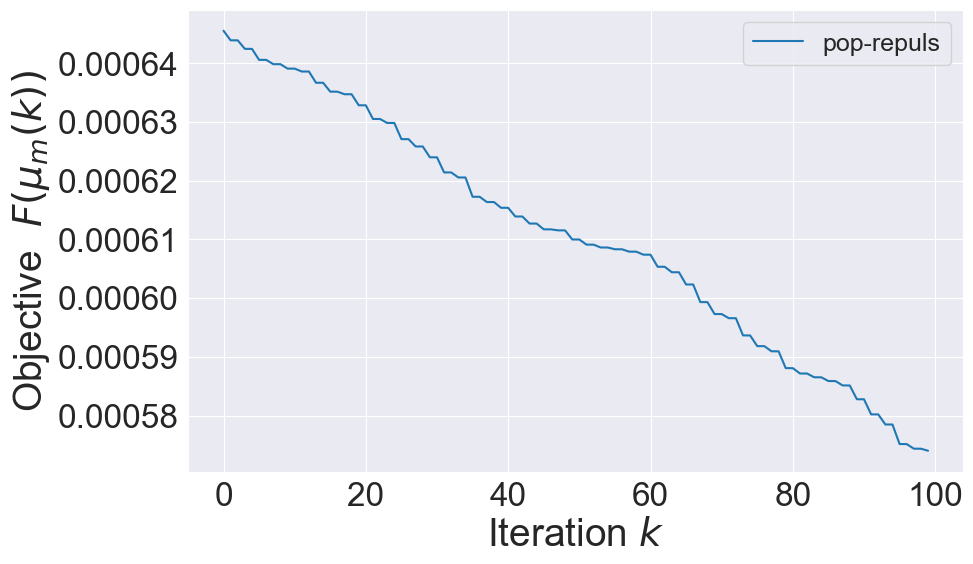

In [31]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')

#plt.yscale('log')

k_min, k_max = 0, 100

plt.plot(np.arange(len(penalized_losses3))[k_min:k_max], penalized_losses3[k_min:k_max], label='pop-repuls')
#plt.plot(np.arange(len(penalized_losses_pop)), penalized_losses_pop, label='pop-conic')
#plt.plot(np.arange(len(penalized_train_losses_mix_coni c)), penalized_train_losses_mix_conic, label='mix-conic')

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Objective $\\ F(\\mu_m(k))$', fontsize=28)
#plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

In [32]:
indx = []
for i in range(len(ms3)-1):
    if ms3[i+1] < ms3[i]:
        indx.append(i)
        
indx

[]

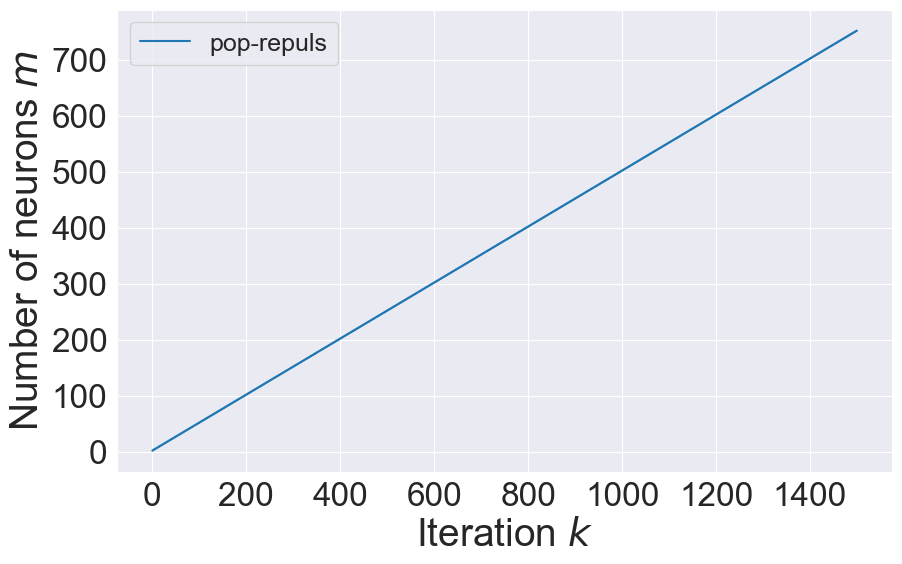

In [33]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(ms3)), ms3, label='pop-repuls')
#plt.plot(np.arange(len(ms_pop)), ms_pop, label='pop-conic')

#plt.plot(np.arange(len(ms_mix_conic)), ms_mix_conic, label='mix-conic')

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Number of neurons $m$', fontsize=28)
#plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

In [34]:
Ks[10]

array([[ 0.00000000e+00,  9.60764380e-01,  9.61236652e-01,
         8.48120700e-01,  8.95895766e-01,  9.74124365e-01,
         9.81534112e-01,  9.86432777e-01],
       [ 9.60764380e-01,  4.44089210e-16,  9.89851795e-01,
         9.75502073e-01,  9.84691515e-01,  9.13211446e-01,
         9.94393038e-01,  9.82620162e-01],
       [ 9.61236652e-01,  9.89851795e-01,  0.00000000e+00,
         9.95169433e-01,  9.81944082e-01,  9.49203357e-01,
         9.97712065e-01,  9.94366974e-01],
       [ 8.48120700e-01,  9.75502073e-01,  9.95169433e-01,
         0.00000000e+00,  9.90085614e-01,  9.92928748e-01,
         9.53831706e-01,  9.87796224e-01],
       [ 8.95895766e-01,  9.84691515e-01,  9.81944082e-01,
         9.90085614e-01, -8.88178420e-16,  9.66532983e-01,
         9.81844789e-01,  8.74134377e-01],
       [ 9.74124365e-01,  9.13211446e-01,  9.49203357e-01,
         9.92928748e-01,  9.66532983e-01,  0.00000000e+00,
         9.92919638e-01,  9.18464857e-01],
       [ 9.81534112e-01,  9.943930

In [35]:
Ks[50]

array([[ 0.00000000e+00,  9.60550488e-01,  9.60967242e-01,
         8.48487628e-01,  8.95744243e-01,  9.74092547e-01,
         9.81545259e-01,  9.86429490e-01,  9.94376019e-01,
         9.91427790e-01,  9.68537676e-01,  9.86495391e-01,
         9.55767351e-01,  9.87977725e-01,  9.42224055e-01,
         9.78730754e-01,  9.92094396e-01,  9.92002352e-01,
         9.56223341e-01,  9.81293748e-01,  9.61939347e-01,
         9.92207060e-01,  9.80534690e-01,  9.86244946e-01,
         9.97425464e-01,  9.84222951e-01,  9.28222862e-01,
         9.98266744e-01],
       [ 9.60550488e-01,  0.00000000e+00,  9.89783606e-01,
         9.75375050e-01,  9.84661289e-01,  9.13315451e-01,
         9.94388385e-01,  9.82654995e-01,  9.97673597e-01,
         9.98153677e-01,  9.46638171e-01,  9.87702831e-01,
         8.57843089e-01,  9.98324709e-01,  7.23925730e-01,
         9.62077687e-01,  9.53483278e-01,  9.95638994e-01,
         9.72388274e-01,  9.75743277e-01,  9.84756178e-01,
         9.69693290e-01,  9.84

In [49]:
k = 20
K_ = Ks[k]
np.size(K_[K_ > 0.1]) / (np.size(K_) - np.shape(K_)[0])

1.0